<a href="https://colab.research.google.com/github/rochak3/-REAL-TIME-ANALYSIS-AND-VISUALIZATION-OF-SOCIAL-MEDIA-SENTIMENTS/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip






File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip


In [ ]:
import tweepy
from nltk.corpus import words
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
import textblob 
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
from PIL import Image
import re
from textblob.classifiers import NaiveBayesClassifier
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
from mpl_toolkits.basemap import Basemap

In [ ]:
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)
data = data.rename(columns={0: 'label', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'text'})
data['label'] = data['label'].replace([0, 4],['neg','pos'])
data.drop(['id','date','query','username'], axis=1, inplace=True)
data = data[['text','label']]
data.sample(frac=1)

,text,label
947916,I'm always excited for it to be sunday just so...,pos
155959,OMG I think my turtle is dying and I dont know...,neg
1301436,@amymurdie Awesome - see you there,pos
677605,@ddlovato holy crap im watching this too! dude...,neg
737544,says It's raining again http://plurk.com/p/12...,neg
...,...,...
285898,doesn't want to be back in England,neg
46834,@DJKCRAY pic was too blurry,neg
689016,Totally up driving in the van at 7:09am. My he...,neg
270949,To all those with exams today.. Good luck and ...,neg


In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=40)
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))


Train dataset shape: (1440000, 2)
Test dataset shape: (160000, 2)


In [ ]:
 train.to_csv('train.csv', index=False)
 test.to_csv('test.csv', index=False)

In [ ]:
emoji_pattern = re.compile("["
         u"\U0001F300-\U0001F5FF"  
         u"\U0001F680-\U0001F6FF"  
         u"\U0001F1E0-\U0001F1FF"  
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def replace_emojis(t):
  emoji_happy = ["\U0001F600", "\U0001F601", "\U0001F602","\U0001F603","\U0001F604","\U0001F605", "\U0001F606", "\U0001F607", "\U0001F609", 
                "\U0001F60A", "\U0001F642","\U0001F643","\U0001F923",r"\U0001F970","\U0001F60D", r"\U0001F929","\U0001F618","\U0001F617",
                r"\U000263A", "\U0001F61A", "\U0001F619", r"\U0001F972", "\U0001F60B", "\U0001F61B", "\U0001F61C", r"\U0001F92A",
                "\U0001F61D", "\U0001F911", "\U0001F917", r"\U0001F92D", r"\U0001F92B","\U0001F914","\U0001F910", r"\U0001F928", "\U0001F610", "\U0001F611",
                "\U0001F636", "\U0001F60F","\U0001F612", "\U0001F644","\U0001F62C","\U0001F925","\U0001F60C","\U0001F614","\U0001F62A",
                "\U0001F924","\U0001F634", "\U0001F920", r"\U0001F973", r"\U0001F978","\U0001F60E","\U0001F913", r"\U0001F9D0"]

  emoji_sad = ["\U0001F637","\U0001F912","\U0001F915","\U0001F922", r"\U0001F92E","\U0001F927", r"\U0001F975", r"\U0001F976", r"\U0001F974",
                       "\U0001F635", r"\U0001F92F", "\U0001F615","\U0001F61F","\U0001F641", r"\U0002639","\U0001F62E","\U0001F62F","\U0001F632",
                       "\U0001F633", r"\U0001F97A","\U0001F626","\U0001F627","\U0001F628","\U0001F630","\U0001F625","\U0001F622","\U0001F62D",
                       "\U0001F631","\U0001F616","\U0001F623"	,"\U0001F61E","\U0001F613","\U0001F629","\U0001F62B", r"\U0001F971",
                       "\U0001F624","\U0001F621","\U0001F620", r"\U0001F92C","\U0001F608","\U0001F47F","\U0001F480", r"\U0002620"]

  words = t.split()
  reformed = []
  for w in words:
    if w in emoji_happy:
      reformed.append("happy")
    elif w in emoji_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t


def replace_smileys(t):
  emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':D',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

  emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('])  

  words = t.split()
  reformed = []
  for w in words:
    if w in emoticons_happy:
      reformed.append("happy")
    elif w in emoticons_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t

def replace_contractions(t):
  cont = {"aren't" : 'are not', "can't" : 'cannot', "couln't": 'could not', "didn't": 'did not', "doesn't" : 'does not',
  "hadn't": 'had not', "haven't": 'have not', "he's" : 'he is', "she's" : 'she is', "he'll" : "he will", 
  "she'll" : 'she will',"he'd": "he would", "she'd":"she would", "here's" : "here is", 
   "i'm" : 'i am', "i've"	: "i have", "i'll" : "i will", "i'd" : "i would", "isn't": "is not", 
   "it's" : "it is", "it'll": "it will", "mustn't" : "must not", "shouldn't" : "should not", "that's" : "that is", 
   "there's" : "there is", "they're" : "they are", "they've" : "they have", "they'll" : "they will",
   "they'd" : "they would", "wasn't" : "was not", "we're": "we are", "we've":"we have", "we'll": "we will", 
   "we'd" : "we would", "weren't" : "were not", "what's" : "what is", "where's" : "where is", "who's": "who is",
   "who'll" :"who will", "won't":"will not", "wouldn't" : "would not", "you're": "you are", "you've":"you have",
   "you'll" : "you will", "you'd" : "you would", "mayn't" : "may not"}
  words = t.split()
  reformed = []
  for w in words:
    if w in cont:
      reformed.append(cont[w])
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

def remove_single_letter_words(t):

  words = t.split()
  reformed = []
  for w in words:
    if len(w) > 1:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

def dataclean(t):
  t = replace_smileys(t) 
  t = t.lower() 
  t = replace_contractions(t)
  t = replace_emojis(t) 
  t = emoji_pattern.sub(r'', t)
  t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) 
  t = re.sub("[0-9]", "", t) 
  t = re.sub('#', '', t) 
  t = re.sub('@[A-Za-z0–9]+', '', t)
  t = re.sub('@[^\s]+', '', t) 
  t = re.sub('rt[\s]+', '', t)
  t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', t)
  t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', t) 
  t = t.replace('\\\\', '')
  t = t.replace('\\', '')
  t = remove_single_letter_words(t) 
  
  return t


In [ ]:
def login():
  try:
    twitterApiKey = "AbvtceCar3FLPsKcmVJ0fx7BR"
    twitterApiSecret = "VSk38eveGoKSqtZZaE52UjTbACvmmu9vSFMzjt5Q0D5nKWcizX"
    twitterApiAccessToken = "1272892404178321409-fo9Gbcnd1ku5YqDhWi2dfDE5PWda2x"
    twitterApiAccessTokenSecret = "bHtUCaHRPQcmCjT5AumScVRwPqn2TWGZw5b12NCvR9jkb"
    auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
    auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
    twitterApi = tweepy.API(auth, wait_on_rate_limit = True)
    return twitterApi
  except:
    print("Error in login")

In [ ]:
def sa(twitterApi,twitterHashTag):
  try:
    tweets = tweepy.Cursor(twitterApi.search,q=twitterHashTag,count=500,lang="en").items(3000);
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweet'])
    data.drop_duplicates()
    data['Tweet'] = data['Tweet'].apply(dataclean)
    return data
  except:
    print("Error in fetching tweets");

In [ ]:
def sen(data):
  def getTextSubjectivity(txt):
      return TextBlob(txt).sentiment.subjectivity
  
  def getTextPolarity(txt):
      return TextBlob(txt).sentiment.polarity
  def getTextAnalysis(a):
      if a < 0:
          return "Negative"
      elif a == 0:
          return "Neutral"
      else:
         return "Positive"

  data['Subjectivity'] = data['Tweet'].apply(getTextSubjectivity)
  data['Polarity'] = data['Tweet'].apply(getTextPolarity)
  data['Score'] = data['Polarity'].apply(getTextAnalysis)
  return data

In [ ]:
def percentage(data):
  positive = data[data['Score'] == 'Positive']
  print(str(positive.shape[0]/(data.shape[0])*100) + " % of positive tweets")
  negative = data[data['Score'] == 'Negative']
  print(str(negative.shape[0]/(data.shape[0])*100) + " % of negative  tweets")

In [ ]:
def bar(data):
  labels = data.groupby('Score').count().index.values
  values = data.groupby('Score').size().values
  plt.bar(labels, values)
  plt.show()

In [ ]:
def xygraph(data):
  for index, row in data.iterrows():
      if row['Score'] == 'Positive':
          plt.scatter(row['Polarity'], row['Subjectivity'], color="green")
      elif row['Score'] == 'Negative':
          plt.scatter(row['Polarity'], row['Subjectivity'], color="red")
      elif row['Score'] == 'Neutral':
          plt.scatter(row['Polarity'], row['Subjectivity'], color="blue")
  
  plt.title('Twitter Sentiment Analysis')
  plt.xlabel('Polarity')
  plt.ylabel('Subjectivity')
  plt.show()

In [ ]:
def wcp(data):
  positive_tweets = data[data["Score"] == "Positive"]
  pos = ' '.join([tweet for tweet in positive_tweets['Tweet']])
  wordCloud = WordCloud(width=600, height=400).generate(pos)
  
  plt.imshow(wordCloud)
  plt.show()

In [ ]:
def wcn(data):
  negative_tweets = data[data["Score"] == "Negative"]
  neg = ' '.join([tweet for tweet in negative_tweets['Tweet']])
  wordCloud = WordCloud(width=600, height=400,background_color="white").generate(neg)
  plt.imshow(wordCloud)
  plt.show()

In [ ]:
def wmap(twitterApi,twitterHashTag):
  map = Basemap()
  map.drawcoastlines()
  tweets = tweepy.Cursor(twitterApi.search,q=twitterHashTag,count=500,lang="en").items(10000);
  for tweet in tweets:
      if(tweet.coordinates!=None):
        x,y = map(tweet.coordinates['coordinates'][0],tweet.coordinates['coordinates'][1])
        map.plot(x,y,marker='o',color='Green')
  plt.show()

Lets start
34.66666666666667 % of positive tweets
15.7 % of negative  tweets


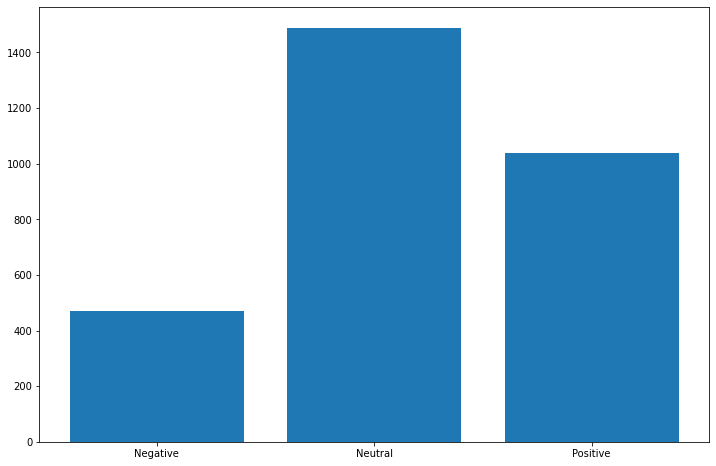

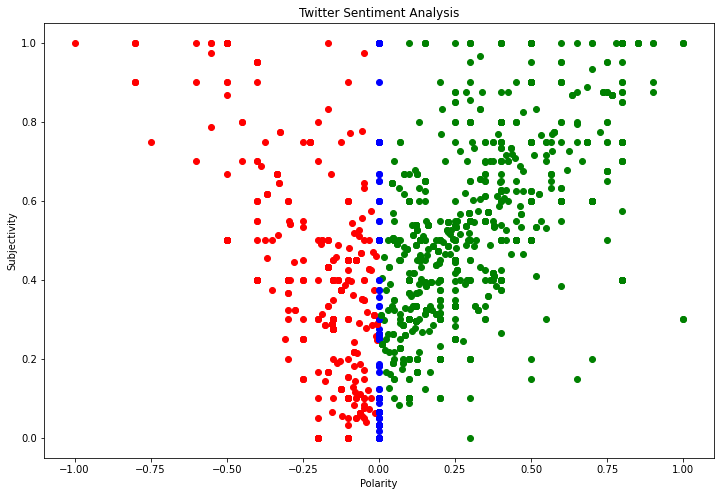

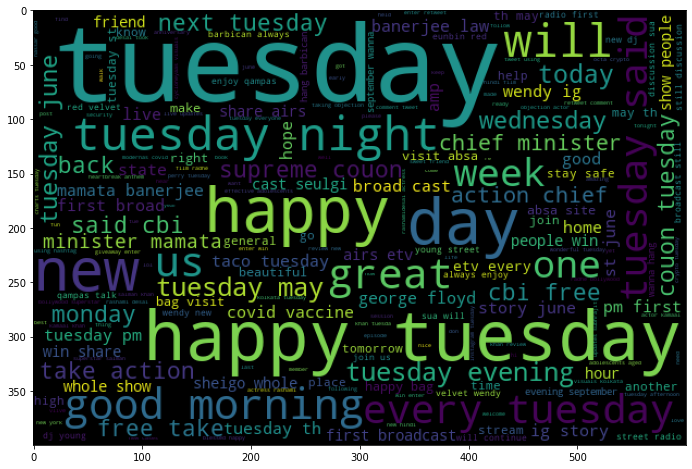

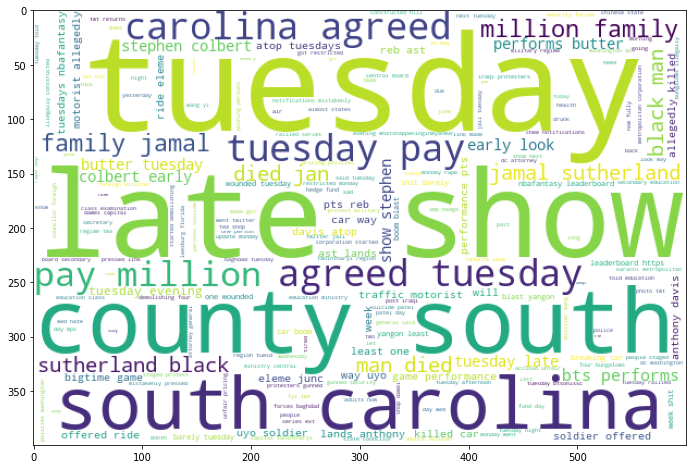

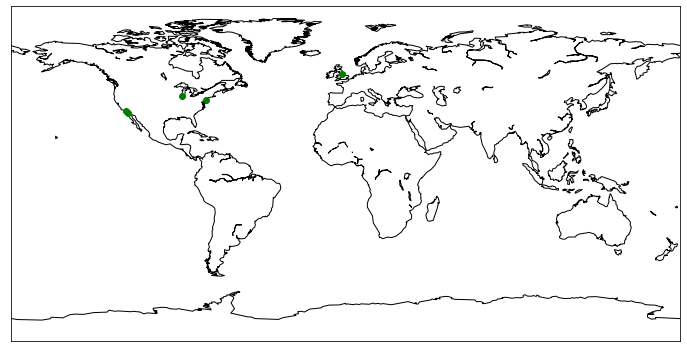

In [ ]:
print("Lets start")
twitterHashTag = input("Enter Hashtag:")
twitterApi = login()
data = sa(twitterApi,twitterHashTag)
data = sen(data)
percentage(data)
bar(data)
xygraph(data)
wcp(data)
wcn(data)
wmap(twitterApi,twitterHashTag)